In [1]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns

Using TensorFlow backend.


In [2]:
# load ascii text and covert to lowercase
path = 'nietzsche.txt'
text = open(path).read().lower()

# create mapping of unique chars to integers and integers to char
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the corpus into chunks of 40 characters, spacing the sequences by 3 characters : sentences
# we will store the next character (the one we need to predict) for every sequence: : next_chars
SEQUENCE_LENGTH = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])


# generating our features and labels. We will use the previously generated sequences and characters 
# that need to be predicted to create one-hot encoded vectors using the char_indices map
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [5]:
# X is the one hot encoded input with size (200285, 40, 57)
X.shape

(200285, 40, 57)

In [6]:
# y is the one hot encoded label with size (200285, 57)
y.shape

(200285, 57)

In [7]:
# model we’re going to train is pretty straight forward. Single LSTM layer with 128 neurons which accepts input of 
# shape (40 — the length of a sequence, 57 — the number of unique characters in our dataset). A fully connected 
# layer (for our output) is added after that. It has 57 neurons and softmax for activation function:

model = Sequential()
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
# model is trained for 20 epochs using RMSProp optimizer and uses 5% of the data for validation:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Instructions for updating:
Use tf.cast instead.
Train on 190270 samples, validate on 10015 samples
Epoch 1/20
190270/190270 [==============================] - 482s 3ms/step - loss: 1.9880 - acc: 0.4188 - val_loss: 1.6830 - val_acc: 0.4853
Epoch 2/20
190270/190270 [==============================] - 468s 2ms/step - loss: 1.6454 - acc: 0.5116 - val_loss: 1.5971 - val_acc: 0.5172
Epoch 3/20
190270/190270 [==============================] - 472s 2ms/step - loss: 1.5536 - acc: 0.5374 - val_loss: 1.5501 - val_acc: 0.5306
Epoch 4/20
190270/190270 [==============================] - 454s 2ms/step - loss: 1.5054 - acc: 0.5500 - val_loss: 1.5373 - val_acc: 0.5416
Epoch 5/20
190270/190270 [==============================] - 328s 2ms/step - loss: 1.4764 - acc: 0.5577 - val_loss: 1.5227 - val_acc: 0.5457
Epoch 6/20
190270/190270 [==============================] - 302s 2ms/step - loss: 1.4530 - acc: 0.5626 - val_loss: 1.5112 - val_acc: 0.5471
Epoch 7/20
190270/190270 [==============================] - 2

In [9]:
# It took a lot of time to train our model. Let’s save our progress and it can be used for test or predict by 
# just loding it from the saved loaction, no need to train the model everytime in order to use it.
model.save('save_models/keras_model_nie.h5')
pickle.dump(history, open("history.p", "wb"))

# load it back
model = load_model('save_models/keras_model_nie.h5')
history = pickle.load(open("history.p", "rb"))

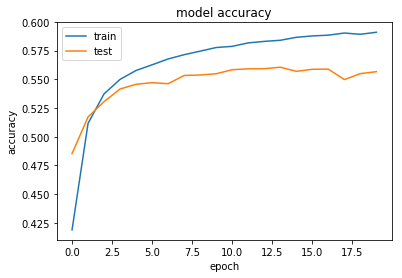

In [10]:
# Evaluation accuracy
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
_=plt.legend(['train', 'test'], loc='upper left')

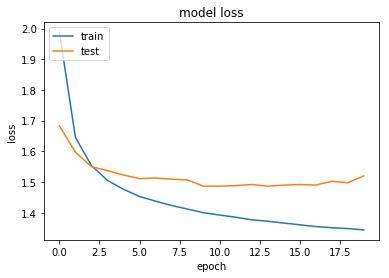

In [11]:
# plot of loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
_=plt.legend(['train', 'test'], loc='upper left')

In [14]:
# we need some helper functions. Let’s start by preparing our input text:
# our sequences must be 40 characters long. So we make a tensor with shape (1, 40, 57)
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

# sample function allows us to ask our model what are the next top n most probable characters.
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

# This function predicts next character until space is predicted
# It does so by repeatedly preparing input, asking our model for predictions and sampling from them.
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

# predict_completions wraps everything and allow us to predict multiple completions.
# it predicts the very first character it shelf without calling the function predict_completion(as this function 
# will terminates once encounter space), from second character it calls predict_completion.
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [20]:
# text from some other book of the same writer
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]


# prediction of 5 most probable set of chars.
for q in quotes:
    seq = q[:40].lower()
    print(seq)

    print(predict_completions(seq, 5))    
    print('\n')

it is not a lack of love, but a lack of 
['the ', 'a ', 'such ', 'man ', 'his ']


that which does not kill us makes us str
['uct ', 'ength ', 'iving ', 'ange ', 'onger ']


i'm not upset that you lied to me, i'm u
['nderstand ', 's ', 'pon ', 'tting ', 'ltimate ']


and those who were seen dancing were tho
['se ', 'ught ', 'rought ', 'ever ', 'ne ']


it is hard enough to remember my opinion
[' of ', ', ', '. ', '--and ', '\nand ']




Apart from the fact that the completions look like proper words (remember, we are training our model on characters, not words), they look pretty reasonable as well! Perhaps better model and/or more training will provide even better results

Ideas to improve the model: <br> 1 Remove all punctuation from the source text, and therefore from the models’ vocabulary. <br>
2 Try a one hot encoded for the input sequences(allready done). <br>
3 Train the model on padded sentences rather than random sequences of characters. <br>
4 Increase the number of training epochs to 100 or many hundreds. <br>
5 Add dropout to the visible input layer and consider tuning the dropout percentage. <br>
6 Tune the batch size, try a batch size of 1 as a (very slow) baseline and larger sizes from there. <br>
7 Add more memory units to the layers and/or more layers. Experiment with scale factors (temperature) when interpreting the prediction probabilities. <br>
8 Change the LSTM layers to be “stateful” to maintain state across batches. <br>
